# Image recognition using convolutional neural networks
With acknowelagements to Maxim Borisyak

Just some imports

In [1]:
import tensorflow as tf
gpu_options = tf.GPUOptions(allow_growth=True,per_process_gpu_memory_fraction=0.333)
s = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('ggplot')

import numpy as np
import h5py

import tensorflow as tf
import keras

Using TensorFlow backend.


## Graph model

Keras allows to build networks of any kind, not just squeantially connected list of layers (a.k.a feed-forward).
In order to do this, we need to define network graph first and then create a model:

```python

input1 = Input(shape=(...))

layer = SuperLayer(params)(input1)
...

network = Model([input1], [output1])
```

In [2]:
from keras.layers import Input, Dense, Concatenate
from keras.models import Model

Let's create an X-shaped network as an exercise.

In [3]:
def make_x_net():
    ### Input layers serve as starting points in networks. 
    input1 = Input(shape=(100, ), name='Input_1')
    dense1 = Dense(units=100, name='Dense_layer_1')(input1)
    
    input2 = Input(shape=(100, ), name='Input_2')
    dense2 = Dense(units=100, name='Dense_layer_2')(input2)
    
    shared = Concatenate(name='Shared_features')([dense1, dense2])
    
    dense3 = Dense(units=100, name='Dense_layer_3')(shared)
    concat1 = Concatenate(name='Concatenate_1')([dense1, dense3])
    output1 = Dense(units=100, name='Output_1')(concat1)
    
    dense4 = Dense(units=100, name='Dense_layer_4')(shared)
    concat2 = Concatenate(name='Concatenate_2')([dense2, dense4])
    output2 = Dense(units=100, name='Output_2')(concat2)
    
    ### model just needs to know which nodes are inputs
    ### and which are outputs
    return Model([input1, input2], [output1, output2])

In [4]:
x_shaped_net = make_x_net()

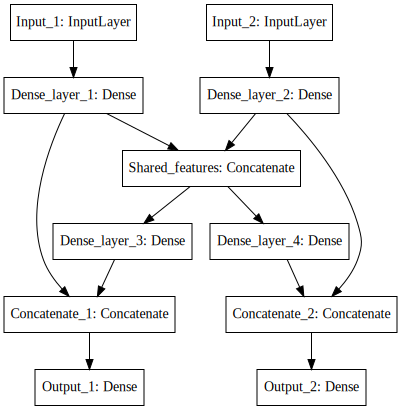

In [5]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(x_shaped_net, show_layer_names=True, show_shapes=False).create(prog='dot', format='svg'))

## CIFAR

In this seminar we work with CIFAR-10 dataset.

https://www.cs.toronto.edu/~kriz/cifar.html

In [6]:
from fetch_cifar import fetch_cifar_dataset
X_train, y_train, X_test, y_test, class_names = fetch_cifar_dataset()

In [7]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


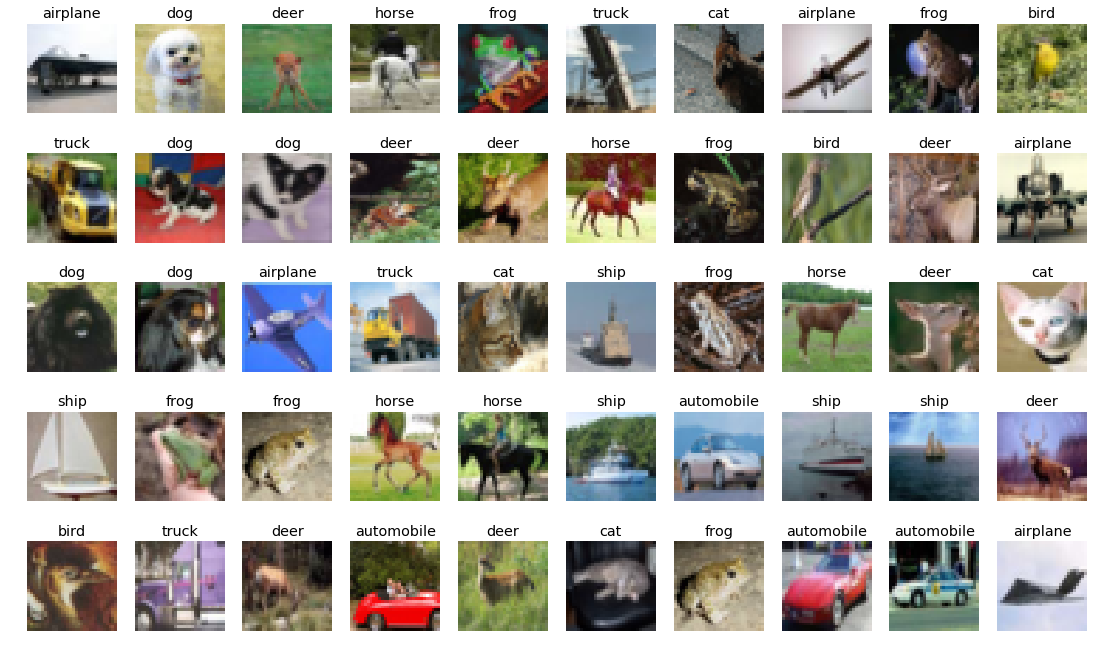

In [8]:
cols = 10
rows = 5
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))

for i in range(cols):
    for j in range(rows):
        k = np.random.randint(0, X_train.shape[0])

        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.set_title('%s' % (class_names[np.where(y_train[k] > 0.0)[0][0]]))
        im = ax.imshow(X_train[k])
plt.show()

In [9]:
### importing keras

from keras.models import Model
from keras.layers import Input, Flatten
from keras.layers import Convolution2D, MaxPooling2D, Dense, GlobalMaxPooling2D
from keras.activations import relu
from keras.regularizers import l2

In [10]:
def make_cifar_cnn():
    inputs = Input(shape=(32, 32, 3))
    net = inputs
    
    leaky_relu = lambda x: relu(x, alpha=5.0e-2)
    regularization_coef = 1.0e-4
    
    net = Convolution2D(
        filters = 4,
        kernel_size=(3, 3),
        padding = 'same',
        activation=leaky_relu,
        kernel_regularizer = l2(regularization_coef)
    )(net)
    net = MaxPooling2D((2, 2))(net)
    
    net = Convolution2D(
        filters = 16,
        kernel_size=(3, 3),
        padding = 'same',
        activation=leaky_relu,
        kernel_regularizer = l2(regularization_coef)
    )(net)
    net = MaxPooling2D((2, 2))(net)
    
    net = Convolution2D(
        filters = 32,
        kernel_size=(3, 3),
        padding = 'same',
        activation=leaky_relu,
        kernel_regularizer = l2(regularization_coef)
    )(net)
    net = MaxPooling2D((2, 2))(net)
    
    net = GlobalMaxPooling2D()(net)
    
    net = Dense(10, activation='softmax', kernel_regularizer = l2(regularization_coef))(net)
    
    return Model(inputs=inputs, outputs=net)

In [11]:
cnn = make_cifar_cnn()

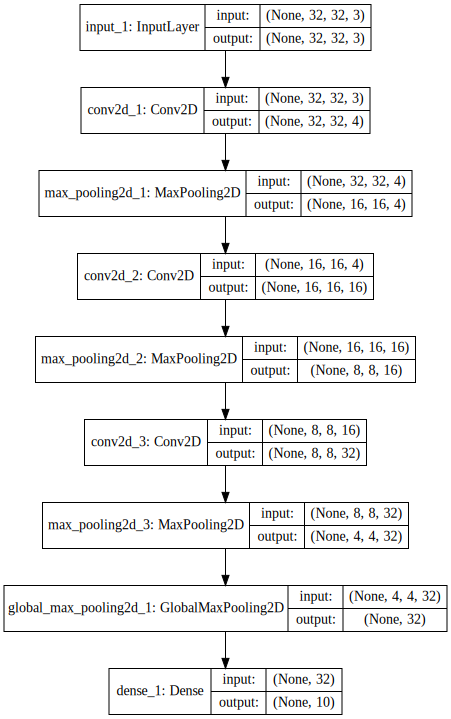

In [12]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(cnn, show_shapes=True).create(prog='dot', format='svg'))

Compiling and training the model.

In [14]:
### since the problem is a classification one;
### cross-entropy is the most common choice.  
from keras.losses import categorical_crossentropy

### pretty usual choice of optimizer
from keras.optimizers import adamax

In [15]:
### compile
cnn.compile(optimizer=adamax(lr=5.0e-3), loss=categorical_crossentropy, metrics=['accuracy'])

In [16]:
### fit
cnn.fit(X_train, y_train, batch_size=32, epochs=4)

Epoch 1/4
50000/50000 [==============================] - 32s - loss: 6.3178 - acc: 0.2204    
Epoch 2/4
50000/50000 [==============================] - 35s - loss: 1.6485 - acc: 0.4040    - ETA: 0s - loss: 1.6490 - acc: 0
Epoch 3/4
50000/50000 [==============================] - 33s - loss: 1.5063 - acc: 0.4622    
Epoch 4/4
50000/50000 [==============================] - 32s - loss: 1.4111 - acc: 0.4972    


### Evaluation

In [17]:
y_predicted = cnn.predict(X_test)
print('Accuracy:', np.mean( np.argmax(y_predicted, axis=1) ==  np.argmax(y_test, axis=1)))

Accuracy: 0.5259


#### One-vs-rest ROC curves

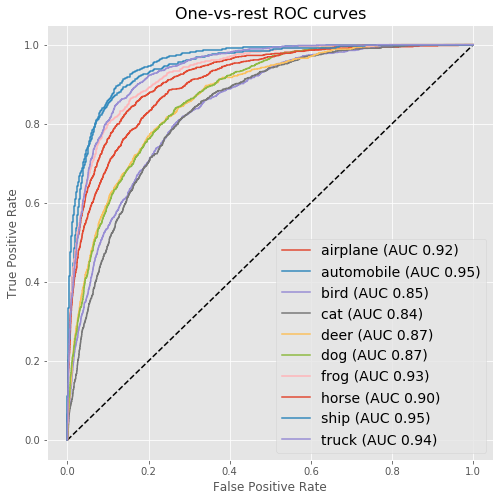

In [18]:
from sklearn.metrics import roc_curve, auc

fprs, tprs = [None] * 10, [None] * 10
aucs = [None] * 10

for i in range(10):
    fprs[i], tprs[i], _ = roc_curve(y_test[:, i], y_predicted[:, i])
    aucs[i] = auc(fprs[i], tprs[i], reorder=True)

plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], '--', color='black')

plt.title('One-vs-rest ROC curves', fontsize=16)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

for i in range(10):
    plt.plot(fprs[i], tprs[i], label='%s (AUC %.2lf)' % (class_names[i], aucs[i]))

plt.legend(fontsize=14)
plt.show()

#### Confusion matrix

In [19]:
y_predicted_classes = np.argmax(y_predicted, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

from sklearn.metrics import confusion_matrix

c_matrix = confusion_matrix(y_true_classes, y_predicted_classes)

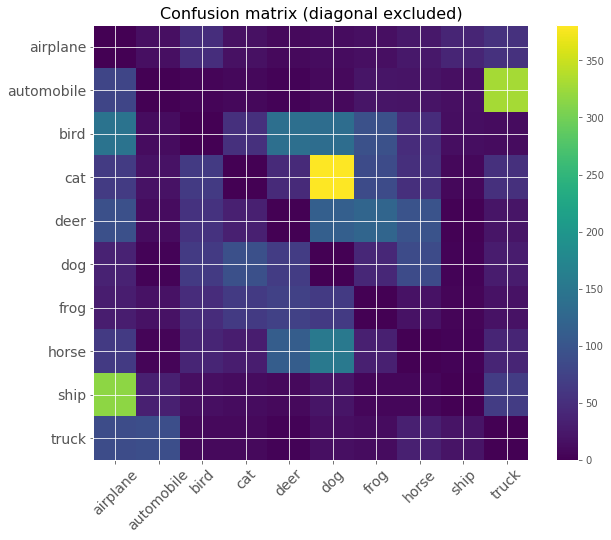

In [20]:
### Diagonal excluded
c_matrix[np.arange(10), np.arange(10)] = 0.0

plt.figure(figsize=(10, 8))
plt.title('Confusion matrix (diagonal excluded)', fontsize=16)
plt.imshow(c_matrix)
plt.xticks(np.arange(10), class_names, rotation=45, fontsize=14)
plt.yticks(np.arange(10), class_names, fontsize=14)
plt.colorbar()
plt.show()

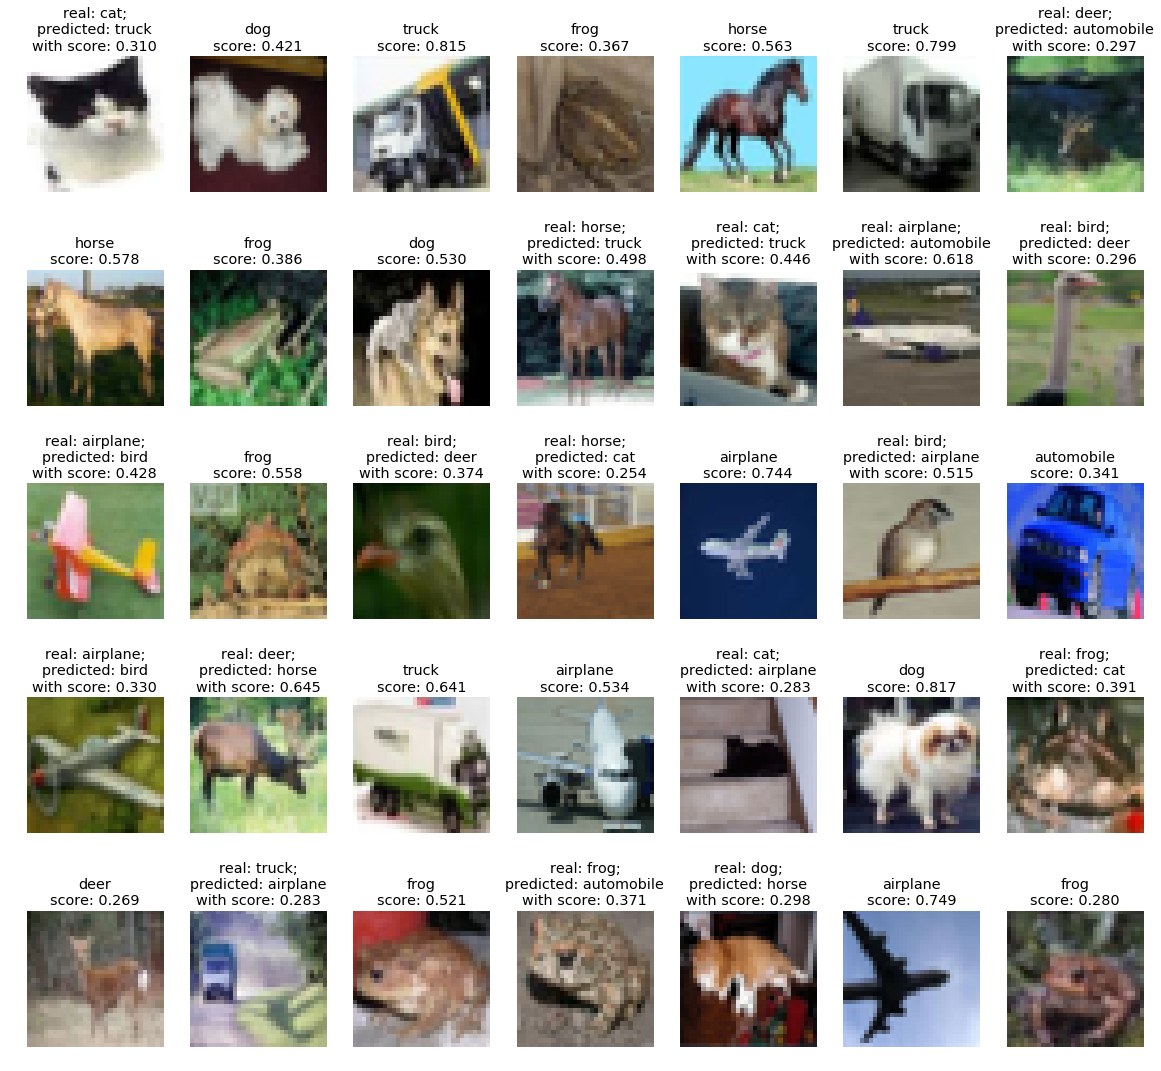

In [21]:
cols = 7
rows = 5
fig = plt.figure(figsize=(3 * cols - 1, 4 * rows - 1))

for i in range(cols):
    for j in range(rows):
        k = np.random.randint(0, X_test.shape[0])
        
        y_pred = y_predicted[k]
        predicted_class = np.argmax(y_pred)
        real_class = np.argmax(y_test[k])
        score = y_pred[predicted_class]

        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        if real_class == predicted_class:
            ax.set_title('%s\nscore: %.3lf' % (class_names[real_class], score))
        else:
            ax.set_title('real: %s;\npredicted: %s\nwith score: %.3lf' % (
                class_names[real_class], class_names[predicted_class], score
            ))
        im = ax.imshow(X_test[k])
plt.show()

### What can you do?

Here is a several tips on how you can improve the base solution:
- add more layers;
- add BatchNormalization;
- play with activations;
- try adjusting regularization;
- increase number of filters;
- make it fully convolutional (get rid of GlobalMaxPooling by convolving/maxpooling up to 1x1 image, you can use Reshape or Flatten layers to get rid of spatial dimensions);
- experiment with the architecture:
    - try use conv-conv-pool

#### Cheat sheet

The standard convolutional networks are built from several types of layers:
- [`Convolution`](https://keras.io/layers/convolutional/), ... - performs ... convolution:
    - filters: number of filters to use, usually, the number of layers is two timex number of layers in the previous conv. layer; 
    - kernel_size: size of the convolutional operator, conventional choice is (3, 3);
    - padding: padding='same' extends sample with zeros so that sample after convolution has the same width and height, padding='valid' performs convolution only in points where kernel and the sample fully overlap.  
    - activation: conventional choice is ReLU or a leaky ReLU.

- [`MaxPooling`](https://keras.io/layers/convolutional/) - pools maximal values from pooling area, average pooling is an alternative.

- [`GlobalMaxPooling`](https://keras.io/layers/convolutional/) - similar to max pool, but pools from the whole sample/image.

- [`Dense`](https://keras.io/layers/core/) - usually is at the end of the network.

#### Conv
![Image](http://deeplearning.net/tutorial/_images/cnn_explained.png)

#### MaxPool

![Image](http://cs231n.github.io/assets/cnn/maxpool.jpeg)

#### Conv network

![Image](http://deeplearning.net/tutorial/_images/mylenet.png)

In [22]:
### importing keras

from keras.models import Model
from keras.layers import Input, Flatten, Reshape
from keras.layers import Convolution2D, MaxPooling2D, Dense, GlobalMaxPooling2D
from keras.layers import BatchNormalization

from keras.activations import relu, elu, softplus, tanh, sigmoid
from keras.regularizers import l2, l1

In [23]:
def make_super_cnn():
    ###
    leaky_relu = lambda x: relu(x, alpha=5.0e-2)
    regularization_coef = 1.0e-6

    inputs = Input(shape=(32, 32, 3))
    net = inputs
    
    ### your network here
    
    ### previous solution     ###
    ### feel free to throw it ###
    net = Convolution2D(
        filters = 4,
        kernel_size=(3, 3),
        padding = 'same',
        activation=leaky_relu,
        kernel_regularizer = l2(regularization_coef)
    )(net)
    net = MaxPooling2D((2, 2))(net)
    
    net = Convolution2D(
        filters = 16,
        kernel_size=(3, 3),
        padding = 'same',
        activation=leaky_relu,
        kernel_regularizer = l2(regularization_coef)
    )(net)
    net = MaxPooling2D((2, 2))(net)
    
    net = Convolution2D(
        filters = 32,
        kernel_size=(3, 3),
        padding = 'same',
        activation=leaky_relu,
        kernel_regularizer = l2(regularization_coef)
    )(net)
    net = MaxPooling2D((2, 2))(net)
    
    net = GlobalMaxPooling2D()(net)
    
    ###
    
    net = Dense(
        10, activation='softmax',
        kernel_regularizer = l2(regularization_coef)
    )(net)
    
    return Model(inputs=inputs, outputs=net)

In [24]:
super_cnn = make_super_cnn()

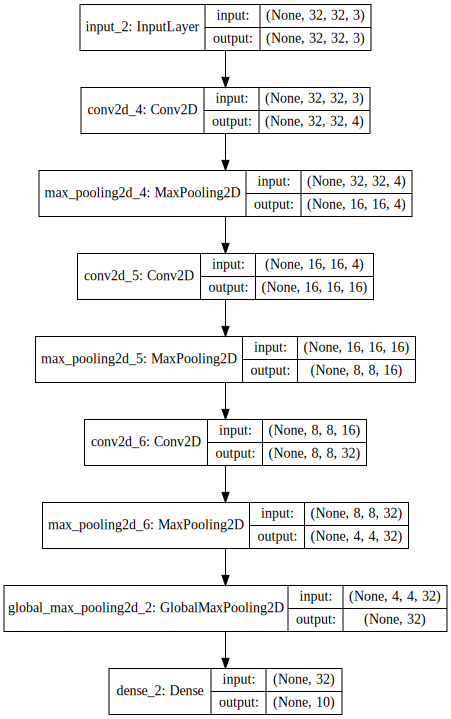

In [24]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(super_cnn, show_shapes=True).create(prog='dot', format='svg'))

In [25]:
### since the problem is a classification one;
### cross-entropy is the most common choice.  
from keras.losses import categorical_crossentropy

### Feel free to play with optimizers
### don't forget to adjust learning rate
from keras.optimizers import adamax

In [26]:
### compile
super_cnn.compile(optimizer=adamax(lr=5.0e-3), loss=categorical_crossentropy, metrics=['accuracy'])

In [ ]:
super_cnn.fit(X_train, y_train, batch_size=32, epochs=2)

### Evaluation

In [ ]:
y_predicted = cnn.predict(X_test)
print('Accuracy:', np.mean( np.argmax(y_predicted, axis=1) ==  np.argmax(y_test, axis=1)))

In [ ]:
from sklearn.metrics import roc_curve, auc

fprs, tprs = [None] * 10, [None] * 10
aucs = [None] * 10

for i in range(10):
    fprs[i], tprs[i], _ = roc_curve(y_test[:, i], y_predicted[:, i])
    aucs[i] = auc(fprs[i], tprs[i], reorder=True)

plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], '--', color='black')

plt.title('One-vs-rest ROC curves')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

for i in range(10):
    plt.plot(fprs[i], tprs[i], label='%s (AUC %.2lf)' % (class_names[i], aucs[i]))

plt.legend(fontsize=14)
plt.show()

In [ ]:
### Diagonal excluded
c_matrix[np.arange(10), np.arange(10)] = 0.0

plt.figure(figsize=(10, 8))
plt.title('Confusion matrix (diagonal excluded)', fontsize=16)
plt.imshow(c_matrix)
plt.xticks(np.arange(10), class_names, rotation=45, fontsize=14)
plt.yticks(np.arange(10), class_names, fontsize=14)
plt.colorbar()
plt.show()